In [351]:
import math
import glob
import copy

import cv2
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


HOUGH_SPACE_SIZE = 512
LINE_MIN_LENGTH = 64/4*3
NON_MAX_SUPPRESSION_DIST = 5

# TODO: pick the required threshold
LINE_EDGE_THRESHOLD = 700


def imshow_with_colorbar(index, img):
    plt.figure(index)
    ax = plt.subplot(111)
    im = ax.imshow(img)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

def convolve(img, kernel):
    
    # convolution output
    image = np.array(copy.deepcopy(img))
    #  Flip the kernel
    kernel = np.flipud(np.fliplr(kernel))
    
    kernel_shape = len(kernel)
    output = []
    # Loop over every pixel of the image
    for x in range(image.shape[0]-kernel_shape+1):
        tmp = []
        for y in range(image.shape[1]-kernel_shape+1):
            # element-wise multiplication of the kernel and the image
            tmp.append((kernel * image[x:x+kernel_shape, y:y+kernel_shape]).sum())
        output.append(tmp)   
    return np.array(output)

def threshold(img, threshold_value):
    return (img>threshold_value).astype(int)

def draw_line_in_hough_space(h_space, y, x):
    # TODO:
    # I propose to use polar coordinates instead of proposed y = a*x + b.
    # They are way easier for implementation.
    # The idea is the same. Short documentation: https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html
    for angle_index in range(HOUGH_SPACE_SIZE):
        angle = angle_index / HOUGH_SPACE_SIZE * (2*math.pi)
        r_index = int(x*np.cos(angle) + y*np.sin(angle))
        h_space[r_index, angle_index] += 1

def count_lines(img, is_debug):
    if is_debug: imshow_with_colorbar(1, img)

    # TODO:
    # pick the kernel for convolve operation, you need to find edges
    k = np.array([[-1, -2, -1],[0, 0, 0], [1, 2, 1]])

    # calculate convolve operation
    k = np.array([[-1, -2, -1],[0, 0, 0], [1, 2, 1]])
    k2 = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
    img1 = convolve(img, k)
    img2 = convolve(img, k2)

    img_c = np.sqrt(img1*img1 + img2*img2)
    
    if is_debug: imshow_with_colorbar(2, img_c)

    # TODO:
    # apply thresholding (the result of the threshold should be array with zeros and ones)
    img_thr = threshold(img_c, LINE_EDGE_THRESHOLD) # LINE_EDGE_THRESHOLD
    if is_debug: imshow_with_colorbar(3, img_thr)

    h_space = np.zeros((HOUGH_SPACE_SIZE, HOUGH_SPACE_SIZE), dtype=np.int)

    # for each coordinate ...
    for y in range(img_thr.shape[0]):
        for x in range(img_thr.shape[1]):
            # if there is edge ...
            if img_thr[y,x] != 0:
                draw_line_in_hough_space(h_space, y, x)
    if is_debug: imshow_with_colorbar(4, h_space)

    # apply threshold for hough space.
    # TODO:
    # pick the threshold to cut-off smaller lines
    # h_space_mask = threshold(h_space, ...)
    h_space_mask = threshold(h_space, LINE_MIN_LENGTH)
    
    if is_debug: imshow_with_colorbar(5, h_space_mask)

    # get indices of non-zero elements
    y_arr, x_arr = np.nonzero(h_space_mask)

    # calculate the lines number,
    # here is simple non maximum suppresion algorithm.
    # it counts only one point in the distance NON_MAX_SUPPRESSION_DIST
    lines_num = 0
    for i in range(len(y_arr)):
        has_neighbour = False
        for j in range(i):
            yi, xi = y_arr[i], x_arr[i]
            yj, xj = y_arr[j], x_arr[j]
            dy = abs(yi - yj)
            dx = abs(xi - xj)
            if dy <= NON_MAX_SUPPRESSION_DIST and \
                (dx <= NON_MAX_SUPPRESSION_DIST or \
                 dx >= HOUGH_SPACE_SIZE - NON_MAX_SUPPRESSION_DIST):  # if x axis represents the angle, than check the distance if the points points that are near 0 degree (for example, distance between 1 deg. and 359 deg. is 2 deg.)
                has_neighbour = True
                break

        if not has_neighbour:
            lines_num += 1
            
    if is_debug: print('lines number: %d' % (int(lines_num/2))); plt.show();
    return int(lines_num/2)


['../images/hw1/test_00.png', '../images/hw1/test_01.png', '../images/hw1/test_02.png', '../images/hw1/test_03.png', '../images/hw1/test_04.png', '../images/hw1/test_05.png', '../images/hw1/test_06.png']
IMAGE : ../images/hw1/test_00.png
lines number: 1


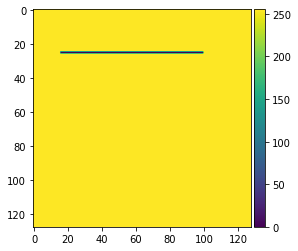

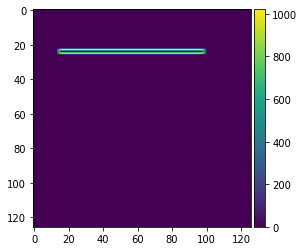

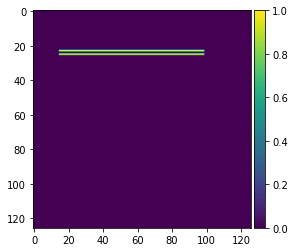

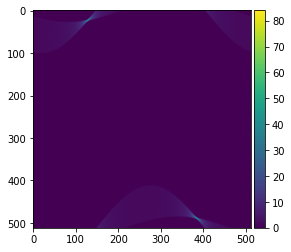

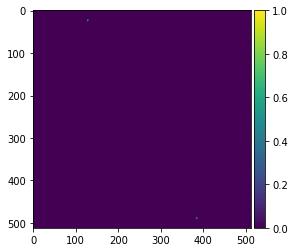

2
Number of lines: 1
IMAGE : ../images/hw1/test_01.png
lines number: 2


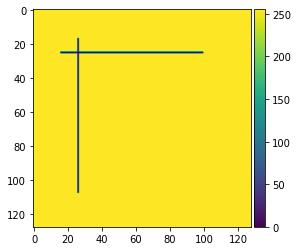

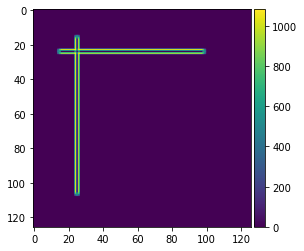

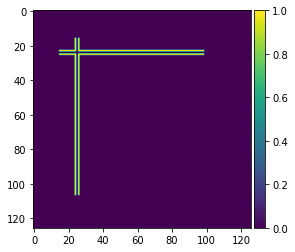

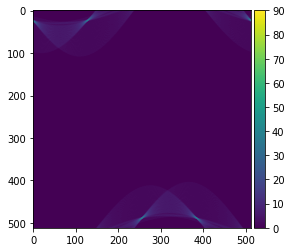

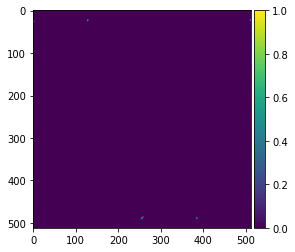

4
Number of lines: 2
IMAGE : ../images/hw1/test_02.png
lines number: 3


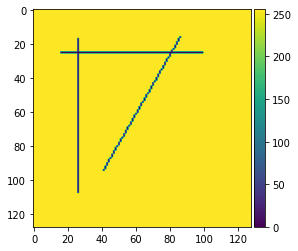

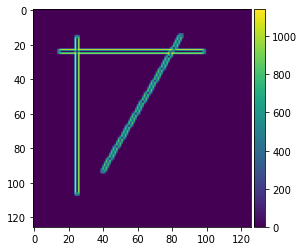

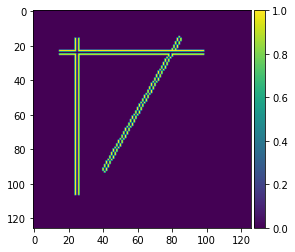

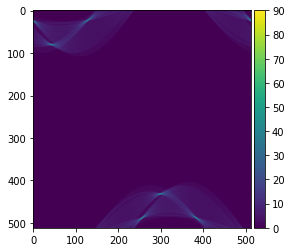

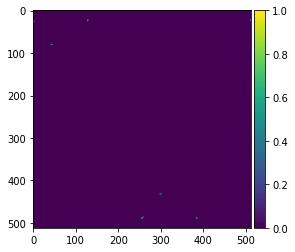

6
Number of lines: 3
IMAGE : ../images/hw1/test_03.png
lines number: 4


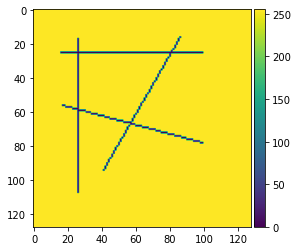

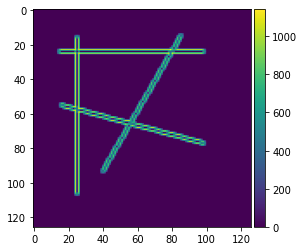

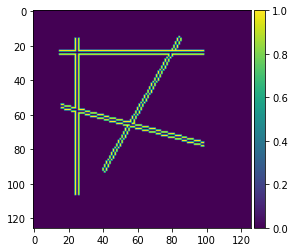

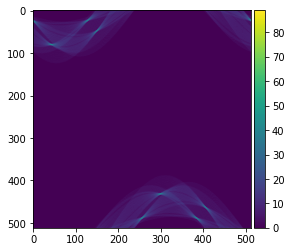

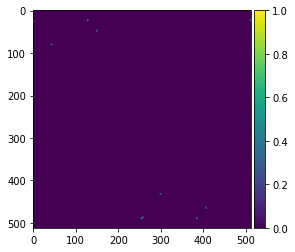

8
Number of lines: 4
IMAGE : ../images/hw1/test_04.png
lines number: 4


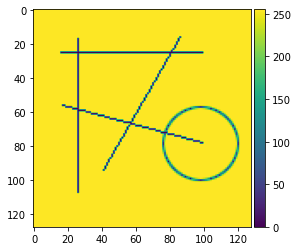

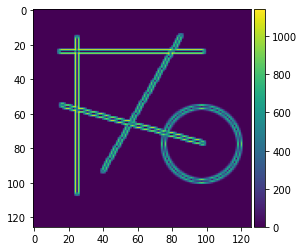

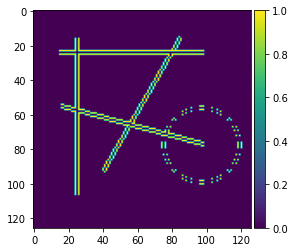

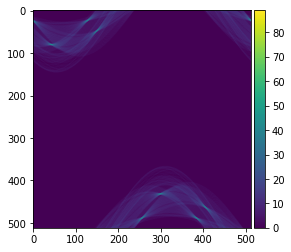

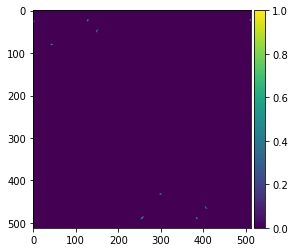

8
Number of lines: 4
IMAGE : ../images/hw1/test_05.png
lines number: 4


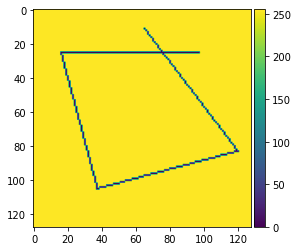

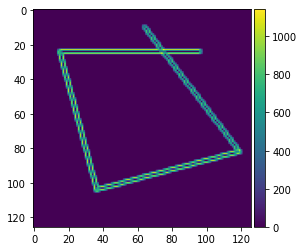

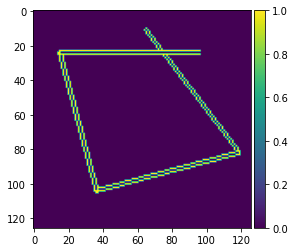

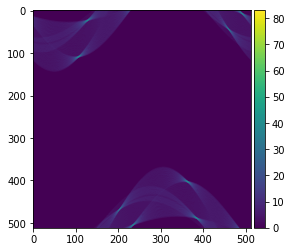

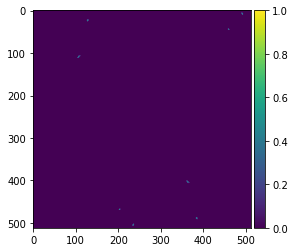

8
Number of lines: 4
IMAGE : ../images/hw1/test_06.png
lines number: 4


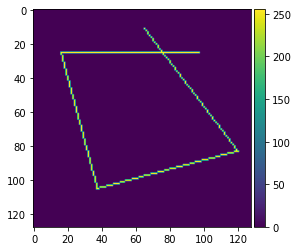

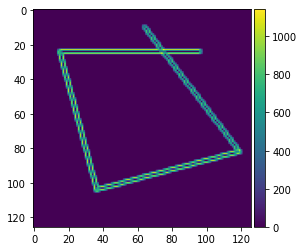

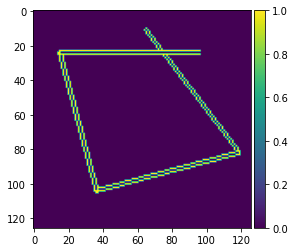

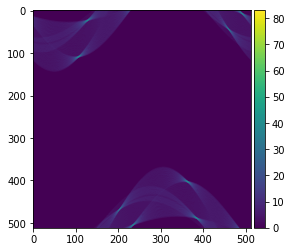

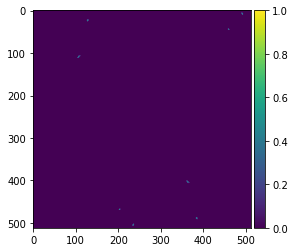

8
Number of lines: 4


In [352]:
fpath_arr = glob.glob('../images/hw1/*.png')
fpath_arr.sort()

print(fpath_arr)

for img_fpath in fpath_arr:
    print('IMAGE : ' + img_fpath)
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    print('Number of lines: %d' % count_lines(img, True))